In [2]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [3]:
import torch
print(torch.__version__)

1.7.0+cu101


In [34]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_LSTM_2_conv(nn.Module):
    def __init__(self, embedding_dim, vocab, hidden_dim=100):
        super(CNN_LSTM_2_conv, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.hidden_dim = hidden_dim

        self.conv1 = nn.Conv2d(1, 50,kernel_size=(2,embedding_dim)) #in_channels, out_chanels, kernel_size
        self.conv2 = nn.Conv2d(1, 50,kernel_size=(2,embedding_dim)) #in_channels, out_chanels, kernel_size
        
        
        self.lstm1 = nn.LSTM(embedding_dim,hidden_dim)
        target_size = 1
        self.fc1 = nn.Linear(hidden_dim, target_size)

    def forward(self, x, lengths):
    #   embeds = self.word_embeddings(sentence)
    #     lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
    #     tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    #     tag_scores = F.log_softmax(tag_space, dim=1)
    #     return tag_scores
        
        x = self.embedding(x)
        # print('x.shape',x.shape)

        x = x.unsqueeze(0)
        # print('x = x.unsqueeze(0)',x.shape)
        x = x.transpose(1,2) # swaps 2nd and 3rd dimension
        # print('x = x.transpose(1,2)',x.shape)
        x = x.transpose(0,1) # swaps 1st and 2nd dimension, now it has the correct input (n_samples,channels, height, width)
        # print('x = x.transpose(0,1)',x.shape)
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x)) 
        # print('x1 = F.relu(self.conv1(x))',x1.shape)
        
        x1 = x1.squeeze(3)
        x2 = x2.squeeze(3)
        # print('x1 = x1.squeeze(3) hahaha',x1.shape)
        pool1 = nn.MaxPool1d(x1.size(2), 1)
        pool2 = nn.MaxPool1d(x2.size(2), 1) #maxpool
        
        x1 = pool1(x1)
        x2 = pool2(x2)
        # print('x1 = x1.squeeze(3) here',x1.shape)

        x = torch.cat((x1,x2),1)
        # print('pool1 = nn.MaxPool1d(x1.size(2), 1)',x.shape)
        # x = concat.view(-1,100)
        # print('x = x.',x.shape)
        
        x = x.transpose(1,2)
        # print('x === x.squeeze(1)',x.shape)
        x = x.transpose(0,1)
        # print('x === x.squeeze(0)',x.shape)


        #  pack the word embeddings in the batch together and 
        # run the RNN on this object
        # x = pack_padded_sequence(x,lengths) 
        # print('x.shape',x.shape)
        x,(h,c) = self.lstm1(x)
        # print('x.shape',x.shape)
        # print('h.shape',h.shape)
        # print('len(h)',len(h))
        # print('(x.view(len(lengths),-1)).shape',(x.view(len(lengths),-1)).shape)
        h_result = self.fc1(h.squeeze(0))
        # h_result = F.log_softmax(tag_space, dim=1) --> change to this with multiple cat
        h_result = torch.sigmoid(h_result)
        

        return h_result.squeeze(1)

In [4]:
import pandas as pd

import torch
import torch.optim as optim

import torchtext
from torchtext import data
import spacy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import argparse
import os


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Baseline(nn.Module):

    def __init__(self, embedding_dim, vocab):
        super(Baseline, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.fc = nn.Linear(embedding_dim, 1)

    def forward(self, x, lengths=None):
        embedded = self.embedding(x)

        average = embedded.mean(0)
        output = self.fc(average).squeeze(1)

        return output

In [6]:
class CNN(nn.Module):
    def __init__(self, embedding_dim, vocab, n_filters, filter_sizes):
        super(CNN, self).__init__()
        self.embed_layer = nn.Embedding.from_pretrained(torch.FloatTensor(vocab.vectors))
        self.conv1 = nn.Conv1d(embedding_dim, n_filters, filter_sizes[0])
        self.conv2 = nn.Conv1d(embedding_dim, n_filters, filter_sizes[1])
        self.fc1 = nn.Linear(embedding_dim, 1)


    def forward(self, x, lengths=None):
        x = self.embed_layer(torch.LongTensor(x))
        x1 = self.conv1(x.permute(1, 2, 0))
        x1 = F.relu(x1)
        x1 = nn.functional.max_pool1d(x1, int(lengths[0] - 1))

        x2 = self.conv2(x.permute(1, 2, 0))
        x2 = F.relu(x2)
        x2 = nn.functional.max_pool1d(x2, int(lengths[0]) - 3)

        x = self.fc1(torch.cat((x1, x2), 1).squeeze())

        return x

In [7]:
class RNN(nn.Module):
    def __init__(self, embedding_dim, vocab, hidden_dim):
        super(RNN, self).__init__()
        self.embed_layer = nn.Embedding.from_pretrained(torch.FloatTensor(vocab.vectors))
        self.GRULayer = nn.GRU(embedding_dim, hidden_dim)
        self.fc1 = nn.Linear(embedding_dim, 1)

    def forward(self, x, lengths=None):
        x = self.embed_layer(torch.LongTensor(x))
        x = nn.utils.rnn.pack_padded_sequence(x, lengths)
        x = self.GRULayer(x)
        x = self.fc1(x[1].squeeze())

        return x


In [25]:
!unzip allmodels.zip

Archive:  allmodels.zip
  inflating: Nov29 10_16pm/severe_toxic_vocab.pkl  
  inflating: Nov29 10_16pm/identity_hate_vocab.pkl  
  inflating: Nov29 10_16pm/threat_vocab.pkl  
  inflating: Nov29 10_16pm/severe_toxic_model_CNN_LSTM.pt  
  inflating: Nov29 10_16pm/identity_hate_model_CNN_LSTM.pt  
  inflating: Nov29 10_16pm/threat_model_CNN_LSTM.pt  
  inflating: Nov29 10_16pm/obscene_model_CNN_LSTM.pt  
  inflating: Nov29 10_16pm/toxic_vocab.pkl  
  inflating: Nov29 10_16pm/insult_vocab.pkl  
  inflating: Nov29 10_16pm/obscene_vocab.pkl  
  inflating: Nov29 10_16pm/insult_model_CNN_LSTM.pt  
  inflating: Nov29 10_16pm/toxic_model_CNN_LSTM.pt  


In [10]:
mkdir data

In [3]:
data = pd.read_csv("/content/data.tsv", sep='\t')
temp, test = train_test_split(data,test_size=0.2,train_size=0.8, stratify = data["label"])
train, valid = train_test_split(temp,test_size = 0.2,train_size =0.8, stratify = temp["label"])
temp, overfit = train_test_split(data,test_size = 0.005,train_size =0.995, stratify = data["label"])
print(train["label"].value_counts())
print(valid["label"].value_counts())
print(test["label"].value_counts())
print(overfit["label"].value_counts())
test.to_csv("/content/data/test.tsv", sep="\t", index = False)
train.to_csv("/content/data/train.tsv", sep="\t", index = False)
valid.to_csv("/content/data/validation.tsv", sep="\t", index = False)
overfit.to_csv("/content/data/overfit.tsv", sep="\t", index = False)

NameError: ignored

In [11]:
def load_model(lr, modeltype, embedding_dim, vocab, hidden_dim, n_filters, filter_sizes):
    loss_fnc = torch.nn.BCEWithLogitsLoss()

    if modeltype == 'baseline':
        model = Baseline(embedding_dim, vocab)
    elif modeltype == 'rnn':
        model = RNN(embedding_dim, vocab, hidden_dim)
    elif modeltype == 'cnn':
        model = CNN(embedding_dim, vocab, n_filters, filter_sizes)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    return model, loss_fnc, optimizer

In [12]:
def evaluate(model, data_iter, loss_fnc):
    sumloss = 0
    sumcorrect = 0
    for i, texts in enumerate(data_iter):
        words, length = texts.comment_text
        labels = texts.obscene
        out = model(words, length)
        temploss = loss_fnc(input=out.squeeze(), target=labels.float())
        correct = (out > 0.5).squeeze().long() == labels
        sumloss += temploss
        sumcorrect += int(correct.sum())
    loss = float(sumloss) / (i + 1)
    return float(sumcorrect)/len(data_iter.dataset), loss

In [13]:
def plot_data(train_acc, valid_acc, test_acc, train_loss, valid_loss, test_loss):

    plt.figure()
    plt.title("Accuracy")
    plt.plot(train_acc, label="Training")
    plt.plot(valid_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.figtext(0.5, -0.05, "Training Final Accuracy: " + str(train_acc[-1]), wrap=True, horizontalalignment='center', fontsize=12)
    plt.figtext(0.5, -0.1, "Validation Final Accuracy: " + str(valid_acc[-1]), wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

    plt.figure()
    plt.title("Loss")
    plt.plot(train_loss, label="Training")
    plt.plot(valid_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


In [14]:
def main(batch_size, lr, epochs, modeltype, emb_dim, rnn_hidden_dim, num_filt):
    ######
    # 3.2 Processing of the data
    # the code below assumes you have processed and split the data into
    # the three files, train.tsv, validation.tsv and test.tsv
    # and those files reside in the folder named "data".
    ######

    # 3.2.1
    TEXT = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
    LABELS = data.Field(sequential=False, use_vocab=False)

    # 3.2.2
    train_data, val_data, test_data = data.TabularDataset.splits(
            path='data/', train='train.tsv',
            validation='validation.tsv', test='test.tsv', format='tsv',
            skip_header=True, fields=[('text', TEXT), ('label', LABELS)])

    # 3.2.3
    train_iter, val_iter, test_iter = data.BucketIterator.splits(
      (train_data, val_data, test_data), batch_sizes=(batch_size, batch_size, batch_size),
	sort_key=lambda x: len(x.text), device=None, sort_within_batch=True, repeat=False)

    # 3.2.4
    TEXT.build_vocab(train_data, val_data, test_data)

    # 4.1
    TEXT.vocab.load_vectors(torchtext.vocab.GloVe(name='6B', dim=100))
    vocab = TEXT.vocab

    print("Shape of Vocab:",TEXT.vocab.vectors.shape)

    filters = (2, 4)
    model, loss_fnc, optimizer = load_model(lr, modeltype, emb_dim, TEXT.vocab, rnn_hidden_dim, num_filt, filters)

    train_acc = []
    train_loss = []
    valid_acc = []
    valid_loss = []
    test_acc = []
    test_loss = []
    for epoch in range(epochs):
        print(epoch)
        sumloss = 0
        sumcorrect = 0
        for i, texts in enumerate(train_iter):
            words, length = texts.text
            labels = texts.label
            optimizer.zero_grad()
            out = model(words, length)
            temploss = loss_fnc(input=out.squeeze(), target=labels.float())
            sumloss += temploss
            temploss.backward()
            optimizer.step()
            correct = (out > 0.5).squeeze().long() == labels
            sumcorrect += int(correct.sum())

        train = evaluate(model, train_iter, loss_fnc)
        train_acc.append(train[0])
        train_loss.append(train[1])
        val = evaluate(model, val_iter, loss_fnc)
        valid_acc.append(val[0])
        valid_loss.append(val[1])
        test = evaluate(model, test_iter, loss_fnc)
        test_acc.append(test[0])
        test_loss.append(test[1])
        print("Epoch: {}| Train acc: {} | Train loss: {} |  Valid acc: {} |  Valid loss: {}"
          .format(epoch + 1, train_acc[epoch + 1], train_loss[epoch + 1],
                  valid_acc[epoch + 1], valid_loss[epoch + 1]))

    torch.save(model,"model_{}.pt".format(modeltype))
    plot_data(train_acc, valid_acc, test_acc, train_loss, valid_loss, test_loss)

In [18]:
def main(batch_size, lr, epochs, model, emb_dim, rnn_hidden_dim, num_filt):
    ######

    # 3.2 Processing of the data

    ######

    COMMENT_TEXT    = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
    # TOXIC           = data.Field(sequential=False, use_vocab=False)
    # SEVERE_TOXIC    = data.Field(sequential=False, use_vocab=False)
    OBSCENE         = data.Field(sequential=False, use_vocab=False)
    # THREAT          = data.Field(sequential=False, use_vocab=False)
    # INSULT          = data.Field(sequential=False, use_vocab=False)
    # IDENTITY_HATE   = data.Field(sequential=False, use_vocab=False)


    train_data, val_data, test_data = data.TabularDataset.splits(
            path='/content/binary/', train='binary_train.csv',
            validation='binary_valid.csv', test='binary_test.csv', format='csv',
            skip_header=True, fields=[('id', None), ('comment_text', COMMENT_TEXT), ('toxic', None), ('severe_toxic', None), ('obscene', OBSCENE), ('threat', None), ('insult', None), ('identity_hate', None)])
            
    train_iter, val_iter, test_iter = data.BucketIterator.splits(
      (train_data, val_data, test_data), batch_sizes=(batch_size, batch_size, batch_size),
	sort_key=lambda x: len(x.comment_text), device=None, sort_within_batch=True, repeat=False)

    COMMENT_TEXT.build_vocab(train_data, val_data, test_data)

    COMMENT_TEXT.vocab.load_vectors(torchtext.vocab.GloVe(name='6B', dim=100))
    vocab = COMMENT_TEXT.vocab

    filter_sizes = (2, 4)   # k = [2, 4]
    model, loss_fnc, optimizer = load_model(lr, model, emb_dim, COMMENT_TEXT.vocab,
                                            rnn_hidden_dim, num_filt, filter_sizes)

    MaxEpoch = epochs
    # start_time = time()

    # variables for every epoch
    train_acc = [0]
    train_loss = [0]
    valid_acc = [0]
    valid_loss = [0]
    test_acc = [0]
    test_loss = [0]

    for epoch in range(MaxEpoch):
        accum_loss = 0
        total_corr = 0
        for i, texts in enumerate(train_iter):
            words, length = texts.comment_text
            labels = texts.obscene
            optimizer.zero_grad()
            prediction = model(words, length)
            batch_loss = loss_fnc(input=prediction.squeeze(), target=labels.float())
            accum_loss += batch_loss
            batch_loss.backward()
            optimizer.step()
            corr = (prediction > 0.5).squeeze().long() == labels
            total_corr += int(corr.sum())

        train_acc.append(float(total_corr) / len(train_iter.dataset))
        train_loss.append(accum_loss / 100)

        val = evaluate(model, val_iter, loss_fnc)
        valid_acc.append(val[0])
        valid_loss.append(val[1])

        test = evaluate(model, test_iter, loss_fnc)
        test_acc.append(test[0])
        test_loss.append(test[1])

        print("Epoch: {}| Train acc: {} | Train loss: {} |  Valid acc: {} |  Valid loss: {}"
              .format(epoch + 1, train_acc[epoch + 1], train_loss[epoch + 1],
                      valid_acc[epoch + 1], valid_loss[epoch + 1]))
    torch.save(model,"model_rnn.pt")
    torch.save(model.state_dict(), 'model_state_dict.pt')
    plot_data(train_acc, valid_acc, test_acc, train_loss, valid_loss, test_loss)
    # torch.save(model, './models/model_{}.pt'.format(args.model))

    ######

Epoch: 1| Train acc: 0.7484835034768457 | Train loss: 0.9729458093643188 |  Valid acc: 0.8 |  Valid loss: 0.38213030497233075
Epoch: 2| Train acc: 0.8200917295457908 | Train loss: 0.7755066752433777 |  Valid acc: 0.8218934911242604 |  Valid loss: 0.34456185941342954
Epoch: 3| Train acc: 0.8381417369433348 | Train loss: 0.718017578125 |  Valid acc: 0.842603550295858 |  Valid loss: 0.3237164462054217
Epoch: 4| Train acc: 0.8449474774374908 | Train loss: 0.6883751749992371 |  Valid acc: 0.8550295857988166 |  Valid loss: 0.3128386250248662
Epoch: 5| Train acc: 0.8506435863293387 | Train loss: 0.6698610186576843 |  Valid acc: 0.8473372781065088 |  Valid loss: 0.308590571085612
Epoch: 6| Train acc: 0.8550821127385708 | Train loss: 0.6564083099365234 |  Valid acc: 0.8568047337278106 |  Valid loss: 0.2991668913099501
Epoch: 7| Train acc: 0.8569314987424175 | Train loss: 0.6512720584869385 |  Valid acc: 0.8414201183431953 |  Valid loss: 0.30682708598949293
Epoch: 8| Train acc: 0.860112442669033

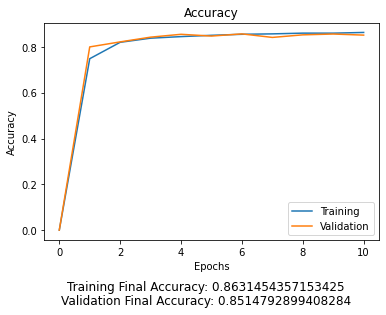

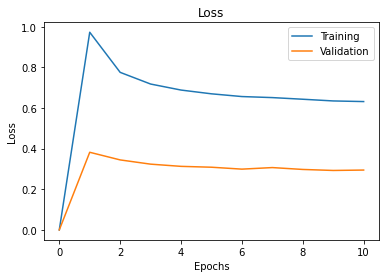

In [19]:
main(64, 0.01, 10, 'baseline', 100, 100, 50)

In [46]:
import spacy
import math

def tokenizer(string):
    nlp = spacy.load('en')
    return nlp(string)

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def subjective_bot():
  model_baseline = torch.load('/content/model_baseline.pt')
  model_rnn = torch.load('/content/model_rnn.pt')
  model_cnn = torch.load('/content/model_cnn.pt')

  COMMENT_TEXT    = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
  # TOXIC           = data.Field(sequential=False, use_vocab=False)
  # SEVERE_TOXIC    = data.Field(sequential=False, use_vocab=False)
  OBSCENE         = data.Field(sequential=False, use_vocab=False)
  # THREAT          = data.Field(sequential=False, use_vocab=False)
  # INSULT          = data.Field(sequential=False, use_vocab=False)
  # IDENTITY_HATE   = data.Field(sequential=False, use_vocab=False)


  text = data.Field(sequential=True, tokenize='spacy', include_lengths=True)
  label = data.Field(sequential=False, use_vocab=False)
  train_data, val_data, test_data = data.TabularDataset.splits(path='/content/data/', train='train.tsv', validation='validation.tsv',
                                      test='test.tsv', skip_header=True, format='tsv',
                                      fields=[('text', text), ('label', label)])
  text.build_vocab(train_data)
  glove_emb = torchtext.vocab.GloVe(name="6B", dim=100)
  text.vocab.load_vectors(glove_emb)
  while True:

      print("Enter a sentence")
      sentence = input()

      sentencelist = tokenizer(sentence)
      temp = []
      for i in range(len(sentencelist)):
          temp.append(text.vocab.stoi[str(sentencelist[i])])
      sentence_tensor = torch.LongTensor([temp]).permute(1, 0)
      sentence_length = torch.LongTensor([len(temp)])

      baseline = sigmoid(model_baseline(sentence_tensor, sentence_length))
      rnn = sigmoid(model_rnn(sentence_tensor, sentence_length))
      cnn = sigmoid(model_cnn(sentence_tensor, sentence_length))

      if baseline > 0.5:
          print('Model baseline: subjective ({})'.format(baseline))
      else:
          print('Model baseline: objective ({})'.format(baseline))
      if rnn > 0.5:
          print('Model rnn: subjective ({})'.format(rnn))
      else:
          print('Model rnn: objective ({})'.format(rnn))
      if cnn > 0.5:
          print('Model cnn: subjective ({})'.format(cnn))
      else:
          print('Model cnn: objective ({})'.format(cnn))

In [50]:
import pickle
import math

def tokenizer(string):
    nlp = spacy.load('en')
    return nlp(string)

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def subjective_bot():
  model_baseline = torch.load('model_rnn.pt')

  COMMENT_TEXT    = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
  # TOXIC           = data.Field(sequential=False, use_vocab=False)
  # SEVERE_TOXIC    = data.Field(sequential=False, use_vocab=False)
  OBSCENE         = data.Field(sequential=False, use_vocab=False)
  # THREAT          = data.Field(sequential=False, use_vocab=False)
  # INSULT          = data.Field(sequential=False, use_vocab=False)
  # IDENTITY_HATE   = data.Field(sequential=False, use_vocab=False)

  text = data.Field(sequential=True, tokenize='spacy', include_lengths=True)
  label = data.Field(sequential=False, use_vocab=False)
  train_data, val_data, test_data = data.TabularDataset.splits(
            path='/content/binary/', train='binary_train.csv',
            validation='binary_valid.csv', test='binary_test.csv', format='csv',
            skip_header=True, fields=[('id', None), ('comment_text', COMMENT_TEXT), ('toxic', None), ('severe_toxic', None), ('obscene', OBSCENE), ('threat', None), ('insult', None), ('identity_hate', None)])
  text.build_vocab(train_data)
  glove_emb = torchtext.vocab.GloVe(name="6B", dim=100)
  text.vocab.load_vectors(glove_emb)

  while True:

      print("Enter a sentence")
      sentence = input()

      sentencelist = tokenizer(sentence)
      temp = []
      for i in range(len(sentencelist)):
          temp.append(text.vocab.stoi[str(sentencelist[i])])
      sentence_tensor = torch.LongTensor([temp]).permute(1, 0)
      sentence_length = torch.LongTensor([len(temp)])
      print(sentence_tensor)

      baseline = model_baseline(sentence_tensor, sentence_length)
      print(baseline)

In [35]:
subjective_bot("allmodels/severe_toxic_model_CNN_LSTM.pt", "allmodels/severe_toxic_vocab.pkl")

Enter a sentence
hi my name is grace
0.5000055164041439
Enter a sentence


KeyboardInterrupt: ignored

In [38]:
import pandas as pd

data = pd.read_csv("binary/binary_test.csv")

In [39]:
data["obscene"].value_counts()

1    845
0    845
Name: obscene, dtype: int64

In [28]:
import pickle
import math

def tokenizer(string):
    nlp = spacy.load('en')
    return nlp(string)

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def subjective_bot(model_path, vocab_path):
  model_baseline = torch.load(model_path)

  with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

  while True:

      print("Enter a sentence")
      sentence = input()

      sentencelist = tokenizer(sentence)
      temp = []
      for i in range(len(sentencelist)):
          temp.append(vocab.stoi[str(sentencelist[i])])
      sentence_tensor = torch.LongTensor([temp]).permute(1, 0)
      sentence_length = torch.LongTensor([len(temp)])

      baseline = model_baseline(sentence_tensor, sentence_length)
      print(baseline)

In [ ]:
torch.save(m.state_dict(), 'mymodule.pt')